# System Setup
List of all the python libraries that are required

- numpy
- pandas
- matplotlib
- seaborn
- wordcloud
- emoji

Run the following command to get all the listed python libraries

`pip install numpy pandas matplotlib seaborn wordcloud emoji`

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
from collections import Counter

# How to obtain Whatsapp Chat data

- Open whatsapp
- Open a Group/Inbox
- Click on the 3 dotted options button
- Click on more
- Click on export chat
- Click on without media
- Export via Email/other IM's/....
- Download to your system rename to chat-data.txt and put it in a folder

As i'm doing chat data analysis i went with `without media` option

# Data Preprocessing

**Regex cheatsheet**
https://www.rexegg.com/regex-quickstart.html

**Regex test - live**
https://regexr.com/

**Datetime format**
http://strftime.org/

Use a custom a regex and datatime format by reffering to the above links if you run into empty df or format errors. As the exports from whatsapp are not standardized.

In [54]:
def rawToDf(file, key):
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%m/%d/%y, %I:%M %p - ',
        '24hr' : '%m/%d/%y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("grp_notif")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['msg'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

# Import Data

In [55]:
df = rawToDf('WhatsApp-Chat-Data.txt', '12hr')

In [56]:
df.head()

,date_time,user,msg
0,2019-07-17 11:30:00,grp_notif,Messages to this group are now secured with en...
1,2019-07-17 11:30:00,grp_notif,"You created group ""AI"""
2,2019-07-17 11:31:00,Rohit,This message was deleted
3,2019-07-17 11:31:00,grp_notif,You added Megha
4,2019-07-17 11:33:00,Rohit,<Media omitted>


In [57]:
df.shape # no. of msgs

(11821, 3)

# Data Cleaning

In [58]:
images = df[df['msg'] == '<Media omitted> '] # no. of images, images are represented by <media omitted>
images.shape

(983, 3)

In [59]:
df['user'].unique()

array(['grp_notif', 'Rohit', 'Megha', 'Adil', 'Shailesh', 'Lalit', 'Amit',
       'Sunny', 'Amu', 'Laxmi', 'Sushma', 'Siddhartha', 'Aromal',
       'Sudarshan', 'PD', 'Yash', 'Bibhas', 'Trishla', 'Sush', 'Seema'],
      dtype=object)

In [60]:
grp_notif = df[df['user'] == 'grp_notif'] # no. of grp notifications
grp_notif.shape

(85, 3)

In [61]:
grp_notif

,date_time,user,msg
0,2019-07-17 11:30:00,grp_notif,Messages to this group are now secured with en...
1,2019-07-17 11:30:00,grp_notif,"You created group ""AI"""
3,2019-07-17 11:31:00,grp_notif,You added Megha
6,2019-07-17 12:41:00,grp_notif,You added Adil
8,2019-07-17 14:05:00,grp_notif,You changed this group's icon
...,...,...,...
10897,2020-07-23 12:46:00,grp_notif,Trishla's security code changed. Tap for more ...
10987,2020-08-04 18:18:00,grp_notif,Yash's security code changed. Tap for more info.
10988,2020-08-04 18:40:00,grp_notif,Yash's security code changed. Tap for more info.
10989,2020-08-04 18:43:00,grp_notif,Yash's security code changed. Tap for more info.


In [62]:
df.drop(images.index, inplace=True) # removing images
df.drop(grp_notif.index, inplace=True) # removing grp_notif

In [63]:
df.head()

,date_time,user,msg
2,2019-07-17 11:31:00,Rohit,This message was deleted
5,2019-07-17 12:06:00,Megha,Where r u all
7,2019-07-17 13:55:00,Adil,Time table ek bar fir se send kar do
10,2019-07-18 08:59:00,Adil,Class kaha par h
11,2019-07-18 11:04:00,Megha,This message was deleted


In [64]:
df.reset_index(inplace=True, drop=True)

In [65]:
df.shape

(10753, 3)

# Lets Discuss on what do we want to get out of this data

* Is raw data enough to get that insight?
* if not, what can be possible way to get that insight?
* Whats the use of that insight?

# Q 1) Who is the most active member of the group. Who is the least active?

In [66]:
df.groupby('user')['msg'].count().sort_values(ascending=False)

user
Amu           1759
PD            1123
Rohit         1056
Adil           913
Laxmi          816
Shailesh       799
Bibhas         725
Siddhartha     613
Lalit          543
Sunny          455
Sush           345
Sudarshan      335
Aromal         298
Yash           297
Trishla        212
Amit           184
Sushma         162
Megha          115
Seema            3
Name: msg, dtype: int64

# Q 2) Count of all the emojis that i have used?

In [76]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    if row['user'] == 'Shailesh':
        emojis_found = r.findall(row['msg'])
        for emoji_found in emojis_found:
            emoji_ctr[emoji_found] += 1

In [77]:
for item in emoji_ctr.most_common(10):
    print(item[0] + ' - ' + str(item[1]))

😂 - 244
🏻 - 48
😄 - 26
👌 - 23
🥳 - 18
🇮🇳 - 17
🤪 - 16
🍻 - 15
🤣 - 14
🎂 - 14


# Q 3) What can my activity say about my sleep cycle?

In [78]:
df.date_time.apply(lambda x: x.hour)

0        11
1        12
2        13
3         8
4        11
         ..
10748    21
10749    21
10750    21
10751    21
10752    21
Name: date_time, Length: 10753, dtype: int64

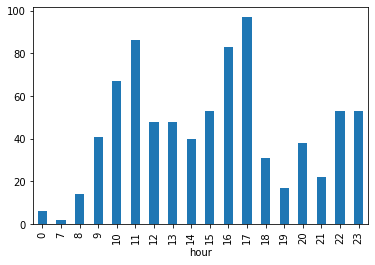

In [79]:
df['hour'] = df['date_time'].apply(lambda x: x.hour)
df[df['user'] == 'Shailesh'].groupby(['hour']).size().sort_index().plot(x='hour', kind='bar');

# Q 4) What is the difference in Weekend vs Weekday usage pattern?

# How many words do I type on average on weekday vs weekend?

In [80]:
df['weekday'] = df['date_time'].apply(lambda x: x.day_name())

In [81]:
df.weekday

0        Wednesday
1        Wednesday
2        Wednesday
3         Thursday
4         Thursday
           ...    
10748       Friday
10749       Friday
10750       Friday
10751       Friday
10752       Friday
Name: weekday, Length: 10753, dtype: object

In [82]:
df['is_weekend'] = df.weekday.isin(['Sunday', 'Saturday'])

In [83]:
df.is_weekend

0        False
1        False
2        False
3        False
4        False
         ...  
10748    False
10749    False
10750    False
10751    False
10752    False
Name: is_weekend, Length: 10753, dtype: bool

In [84]:
msgs_per_user = df['user'].value_counts(sort=True)
msgs_per_user

Amu           1759
PD            1123
Rohit         1056
Adil           913
Laxmi          816
Shailesh       799
Bibhas         725
Siddhartha     613
Lalit          543
Sunny          455
Sush           345
Sudarshan      335
Aromal         298
Yash           297
Trishla        212
Amit           184
Sushma         162
Megha          115
Seema            3
Name: user, dtype: int64

In [85]:
top5_user = msgs_per_user.index.tolist()[:5]
top5_user

['Amu', 'PD', 'Rohit', 'Adil', 'Laxmi']

In [86]:
df_top5 = df.copy()
df_top5 = df_top5[df_top5.user.isin(top5_user)]
df_top5.head()

,date_time,user,msg,hour,weekday,is_weekend
0,2019-07-17 11:31:00,Rohit,This message was deleted,11,Wednesday,False
2,2019-07-17 13:55:00,Adil,Time table ek bar fir se send kar do,13,Wednesday,False
3,2019-07-18 08:59:00,Adil,Class kaha par h,8,Thursday,False
6,2019-07-18 15:14:00,Adil,Nhi h,15,Thursday,False
7,2019-07-18 16:36:00,Adil,This message was deleted,16,Thursday,False


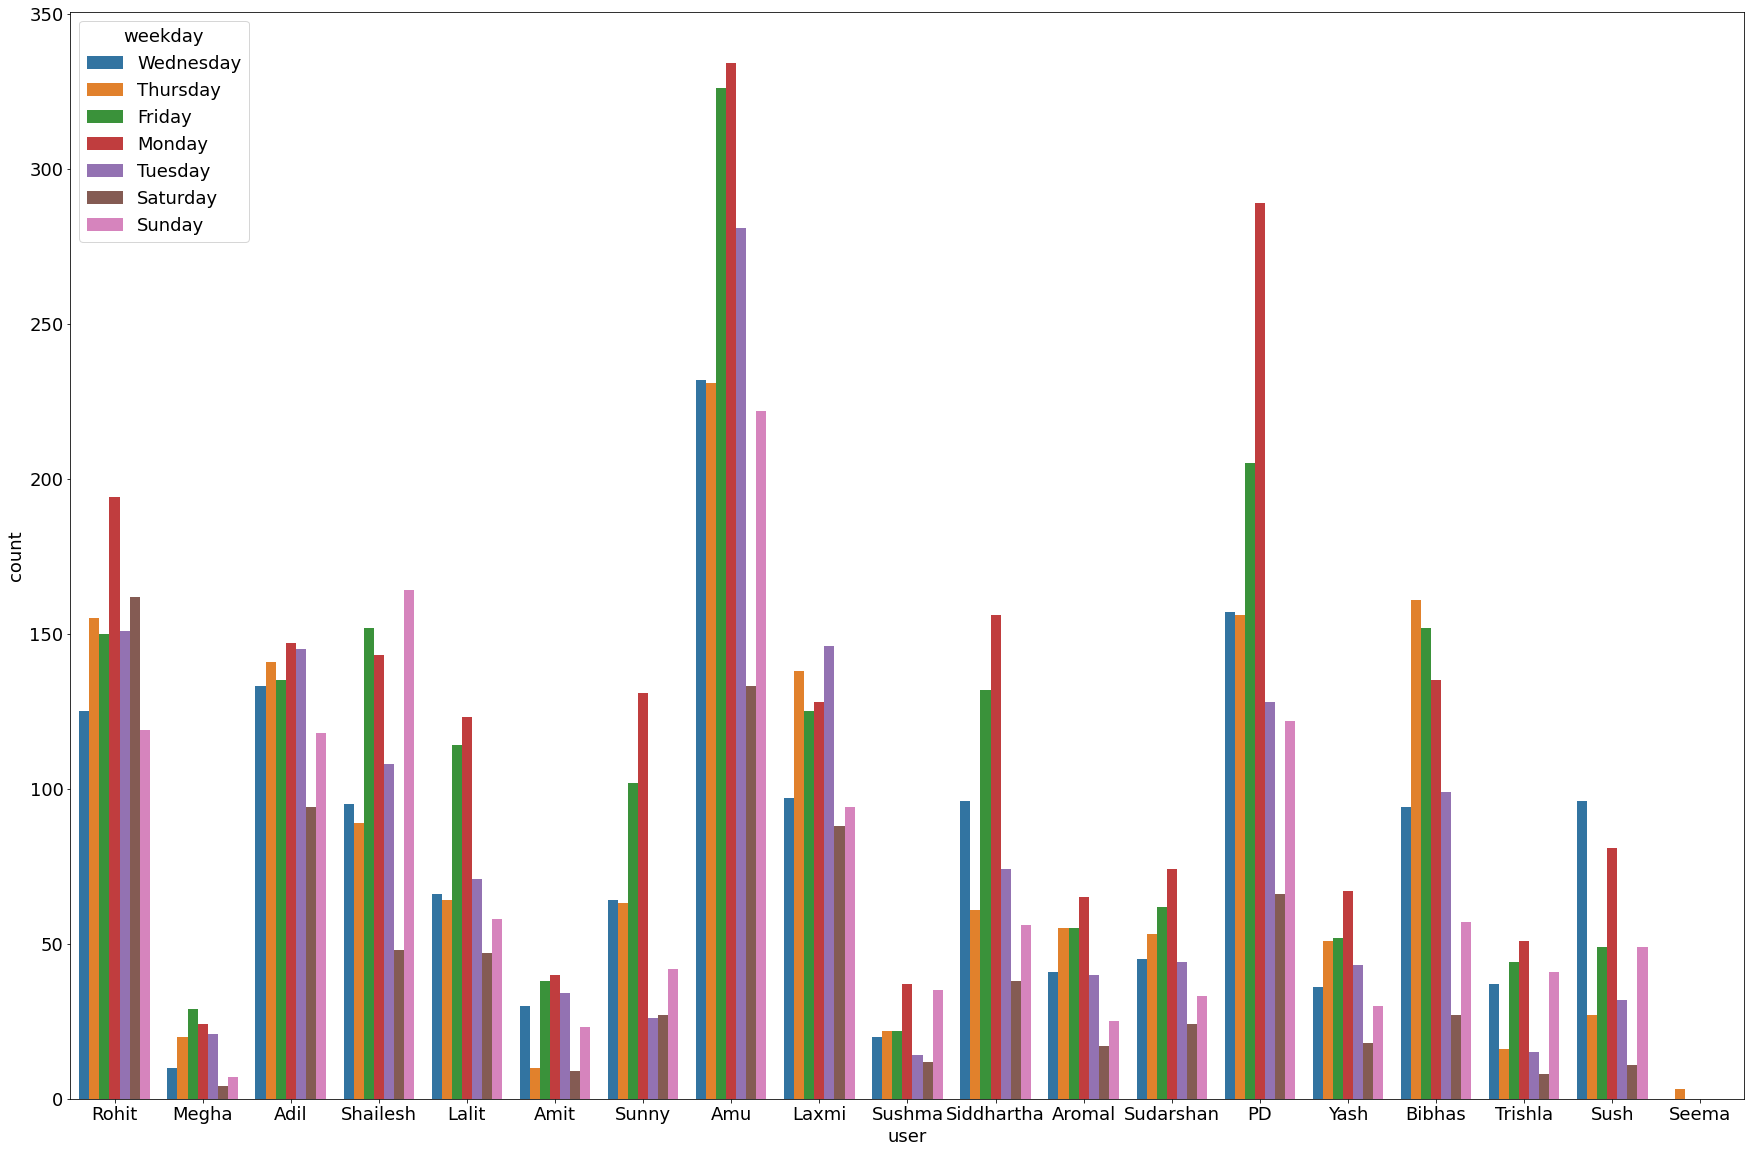

In [87]:
plt.figure(figsize=(30,20))
plt.rcParams.update({'font.size': 18})
sns.countplot(x='user', hue='weekday', data = df);

In [88]:
df_top5['is_weekend'] = df_top5.weekday.isin(['Sunday', 'Saturday'])

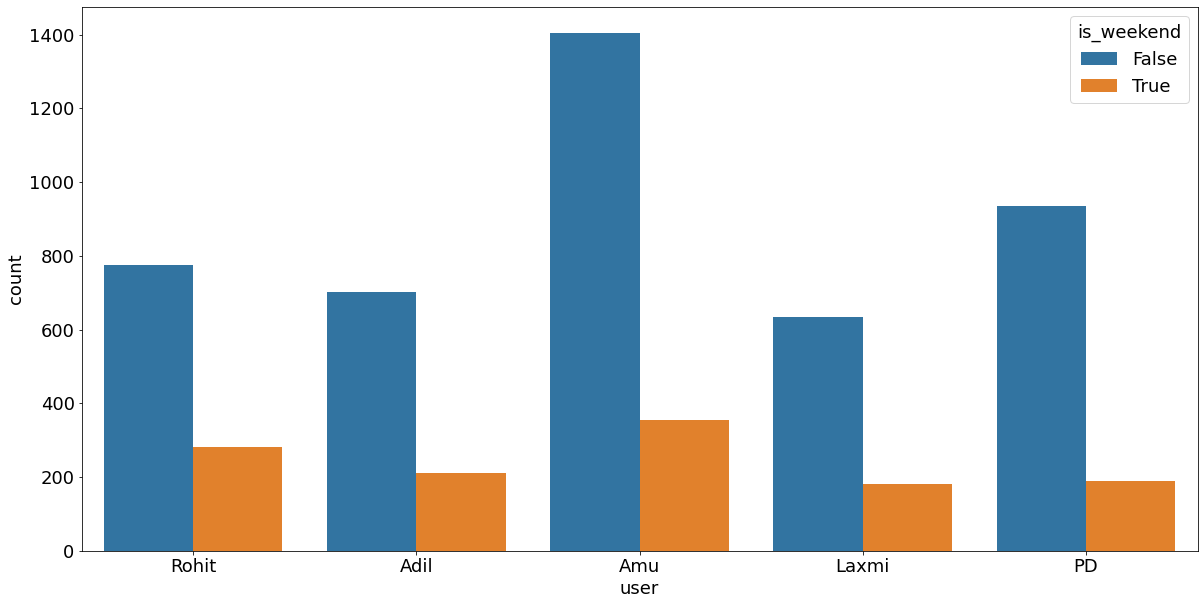

In [89]:
plt.figure(figsize=(20,10))
sns.countplot(x='user', hue='is_weekend', data=df_top5);

In [90]:
def word_count(val):
    return len(val.split())

In [91]:
df['no_of_words'] = df['msg'].apply(word_count)

In [92]:
df_top5['no_of_words'] = df_top5['msg'].apply(word_count)

In [93]:
total_words_weekday = df[df['is_weekend'] == False]['no_of_words'].sum()
total_words_weekday

41529

In [94]:
total_words_weekend = df[df['is_weekend']]['no_of_words'].sum()
total_words_weekend

11024

In [95]:
total_words_weekday/5 # average words on a weekday

8305.8

In [96]:
total_words_weekend/2 # average words on a weekend

5512.0

In [97]:
df.groupby('user')['no_of_words'].sum().sort_values(ascending=False)

user
Amu           7256
Rohit         6274
PD            5523
Laxmi         5126
Adil          3994
Bibhas        3805
Siddhartha    3176
Shailesh      3060
Lalit         2807
Sunny         2532
Sudarshan     1387
Yash          1370
Aromal        1333
Sush          1325
Amit          1084
Sushma        1038
Trishla        970
Megha          471
Seema           22
Name: no_of_words, dtype: int64

In [110]:
(df_top5.groupby('user')['no_of_words'].sum()/df_top5.groupby('user').size()).sort_values(ascending=False)

user
Laxmi    6.281863
Rohit    5.941288
PD       4.918077
Adil     4.374589
Amu      4.125071
dtype: float64

In [124]:
wordPerMsg_weekday_vs_weekend = (df_top5.groupby(['user', 'is_weekend'])['no_of_words'].sum()/df_top5.groupby(['user', 'is_weekend']).size())
wordPerMsg_weekday_vs_weekend

user   is_weekend
Adil   False         4.238231
       True          4.825472
Amu    False         4.115385
       True          4.163380
Laxmi  False         6.037855
       True          7.131868
PD     False         4.895187
       True          5.031915
Rohit  False         5.663226
       True          6.708185
dtype: float64

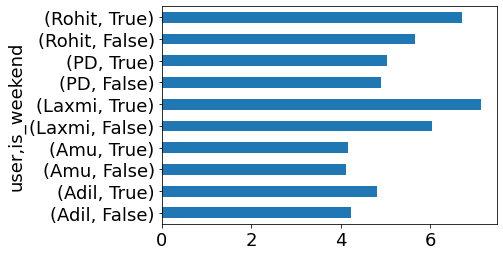

In [125]:
wordPerMsg_weekday_vs_weekend.plot(kind='barh');

# Q 5) Most Usage - Time of Day

In [133]:
x = df.groupby(['hour', 'weekday'])['msg'].size().reset_index()
x2 = x.pivot("hour", 'weekday', 'msg')
x2.head()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,18.0,16.0,NaN,21.0,13.0,22.0,43.0
1,1.0,1.0,1.0,8.0,4.0,2.0,NaN
2,NaN,NaN,NaN,12.0,NaN,1.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,1.0,NaN,NaN,NaN,NaN,NaN,2.0


In [134]:
x2

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,18.0,16.0,NaN,21.0,13.0,22.0,43.0
1,1.0,1.0,1.0,8.0,4.0,2.0,NaN
2,NaN,NaN,NaN,12.0,NaN,1.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,1.0,NaN,NaN,NaN,NaN,NaN,2.0
6,1.0,3.0,NaN,5.0,NaN,NaN,6.0
7,7.0,16.0,1.0,15.0,23.0,8.0,16.0
8,78.0,53.0,6.0,54.0,52.0,30.0,49.0
9,116.0,137.0,47.0,78.0,142.0,106.0,140.0


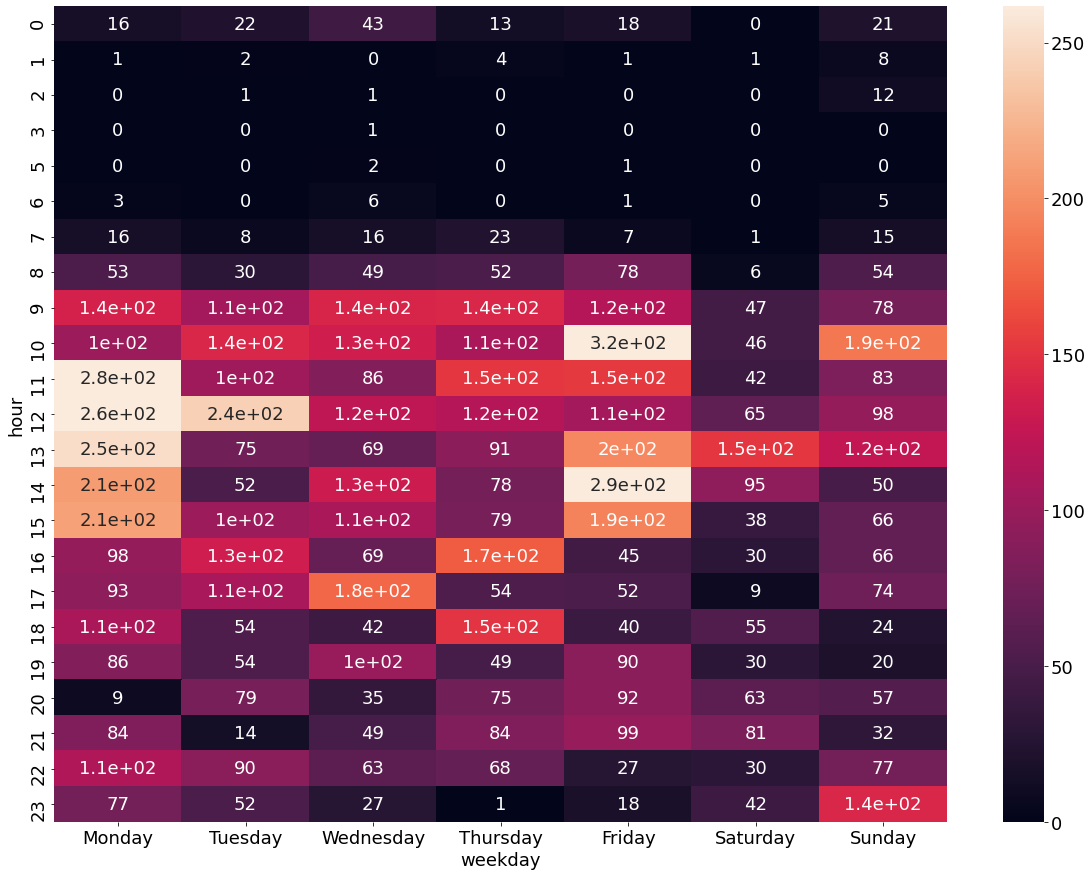

In [143]:
days = ["Monday", 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(20,15))
sns.heatmap(x2[days].fillna(0), annot=True, robust=True);

# Q 6) In any group, do I have any inclination towards responding to someone?

In [144]:
df[df['user'] == 'Shailesh'][1:6]

,date_time,user,msg,hour,weekday,is_weekend,no_of_words
11,2019-07-19 13:06:00,Shailesh,Invite link,13,Friday,False,2
26,2019-07-22 13:58:00,Shailesh,Class room no 116,13,Monday,False,4
27,2019-07-22 13:58:00,Shailesh,TA,13,Monday,False,1
46,2019-07-25 09:14:00,Shailesh,IOT class TC-206,9,Thursday,False,3
101,2019-08-01 09:05:00,Shailesh,TF 206,9,Thursday,False,2


In [145]:
my_msgs_index = np.array(df[df['user']=='Shailesh'].index)
print(my_msgs_index, my_msgs_index.shape)

[   10    11    26    27    46   101   102   105   157   160   236   298
   356   359   420   565   626   628   629   630   639   763   766   767
   772   795   881   882   883   935  1031  1032  1033  1034  1080  1083
  1109  1122  1194  1200  1203  1205  1209  1210  1212  1213  1215  1347
  1351  1352  1355  1356  1357  1416  1417  1420  1614  1692  1693  1695
  1747  1757  1760  1761  1766  1878  1880  1941  1950  1956  1957  1968
  2175  2177  2196  2234  2428  2430  2444  2448  2461  2471  2474  2528
  2529  2580  2630  2657  2667  2699  2708  2711  2714  2756  2757  2773
  2774  2775  2784  2797  2798  2859  2885  2912  2924  2964  2969  2970
  2972  2984  2993  3004  3006  3187  3217  3246  3373  3431  3434  3439
  3457  3458  3500  3508  3520  3521  3545  3546  3551  3597  3667  3668
  3675  3679  3690  3728  3730  3731  3789  3892  3906  3926  3928  3929
  3972  3988  4076  4090  4159  4163  4198  4212  4220  4244  4245  4257
  4258  4261  4313  4314  4316  4354  4380  4389  4

In [146]:
prev_msgs_index = my_msgs_index - 1
print(prev_msgs_index, prev_msgs_index.shape)

[    9    10    25    26    45   100   101   104   156   159   235   297
   355   358   419   564   625   627   628   629   638   762   765   766
   771   794   880   881   882   934  1030  1031  1032  1033  1079  1082
  1108  1121  1193  1199  1202  1204  1208  1209  1211  1212  1214  1346
  1350  1351  1354  1355  1356  1415  1416  1419  1613  1691  1692  1694
  1746  1756  1759  1760  1765  1877  1879  1940  1949  1955  1956  1967
  2174  2176  2195  2233  2427  2429  2443  2447  2460  2470  2473  2527
  2528  2579  2629  2656  2666  2698  2707  2710  2713  2755  2756  2772
  2773  2774  2783  2796  2797  2858  2884  2911  2923  2963  2968  2969
  2971  2983  2992  3003  3005  3186  3216  3245  3372  3430  3433  3438
  3456  3457  3499  3507  3519  3520  3544  3545  3550  3596  3666  3667
  3674  3678  3689  3727  3729  3730  3788  3891  3905  3925  3927  3928
  3971  3987  4075  4089  4158  4162  4197  4211  4219  4243  4244  4256
  4257  4260  4312  4313  4315  4353  4379  4388  4

In [147]:
df_replies = df.iloc[prev_msgs_index].copy()
df_replies.shape

(799, 7)

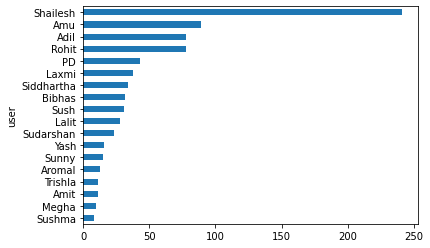

In [150]:
df_replies.groupby(['user'])['msg'].size().sort_values().sort_values().plot(kind = 'barh');
plt.rcParams.update({'font.size': 10})

# Q 7) Which are the most common words?

In [156]:
comment_words = ' '
stopwords = STOPWORDS.update(['ha', 'ko', 'dekh', 'apne', 'ho', 'lo', 'bhai', 'kal', 'wah', 'na', 'matlab', 'yeah', 'kya', 'are', 'okay', 'ok', 'nahi'])
  
for val in df.msg.values: 
    val = str(val) 
    tokens = val.split() 
        
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

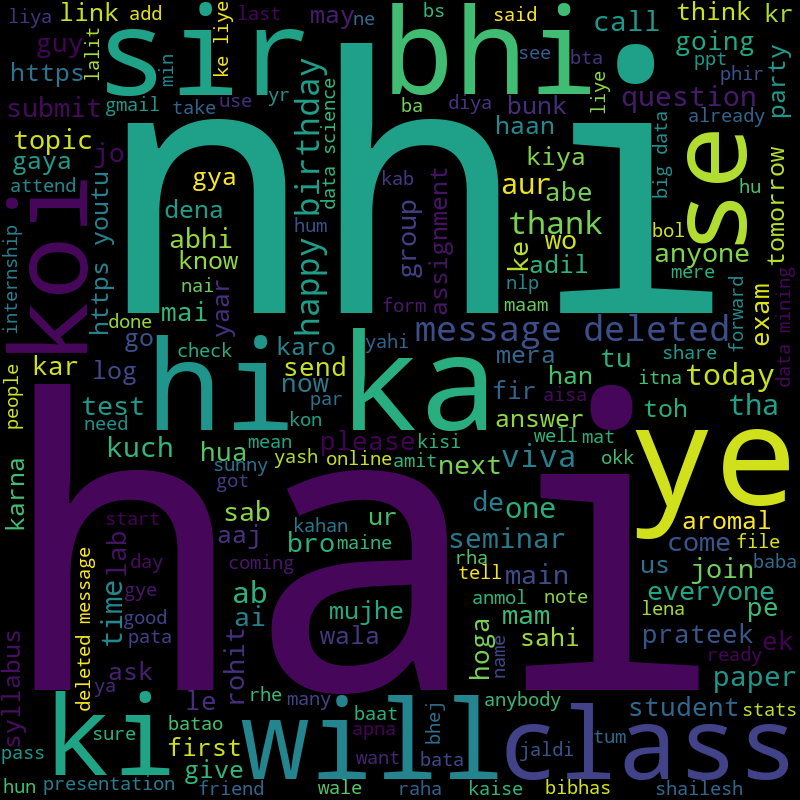

In [157]:
wordcloud.to_image()